In [1]:
### Magic functinos
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [2]:
### imports
import warnings
warnings.simplefilter('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import mean_ci
from mliv.neuralnet import AGMMEarlyStop as AGMM
from mliv.neuralnet.moments import avg_small_diff
from sklearn.ensemble import RandomForestRegressor

## $\ell_2$-Regularized AGMM with Neural Net Test Function

We solve the problem:
\begin{equation}
\min_{\theta} \max_{w} \frac{1}{n} \sum_i (y_i - h_{\theta}(x_i)) f_w(z_i) - f_w(z_i)^2
\end{equation}
where $h_{\theta}$ and $f_w$ are two neural nets.

In [3]:
n = 2000
n_z = 1
n_t = 1
iv_strength = .7
fname = 'sigmoid'
dgp_num = 5

Z, T, Y, true_fn = get_data(100000, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
true = np.mean(avg_small_diff(T, true_fn, device='cpu'))
print(f'True: {true:.4f}')

True: 0.1906


In [4]:
def exp(it):
    np.random.seed(it)
    
    #####
    # Neural network parameters
    ####
    p = 0.1 # dropout prob of dropout layers throughout notebook
    n_hidden = 100 # width of hidden layers throughout notebook

    learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                            #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))

    # For any method that uses an unstructured adversary test function f(z)
    adversary_fn = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                                 #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                                 nn.Dropout(p=p), nn.Linear(n_hidden, 1))

    learner_lr = 1e-4
    adversary_lr = 1e-4
    learner_l2 = 1e-3
    adversary_l2 = 1e-4
    n_epochs = 300
    bs = 100
    burn_in = 100
    device = None
    
    ######
    # Train test split
    Z, T, Y, true_fn = get_data(n, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
    Z_train, Z_val, T_train, T_val, Y_train, Y_val = train_test_split(Z, T, Y, test_size=.5, shuffle=True)
    Z_train, T_train, Y_train = map(lambda x: torch.Tensor(x), (Z_train, T_train, Y_train))
    Z_val, T_val, Y_val = map(lambda x: torch.Tensor(x).to(device), (Z_val, T_val, Y_val))
    ######
    
    #####
    # Train IV function and riesz representer
    #####
    np.random.seed(12356)
    agmm = AGMM(learner, adversary_fn).fit(Z_train, T_train, Y_train, Z_val, T_val, Y_val,
                                           learner_lr=learner_lr, adversary_lr=adversary_lr,
                                           learner_l2=learner_l2, adversary_l2=adversary_l2,
                                           n_epochs=n_epochs, bs=bs, logger=None,
                                           model_dir=f'agmm_model_{it}', device=device)

    reisz = AGMM(learner, adversary_fn).fit(Z_train, T_train, Y_train, Z_val, T_val, Y_val,
                                            learner_lr=learner_lr, adversary_lr=adversary_lr,
                                            learner_l2=learner_l2, adversary_l2=adversary_l2,
                                            n_epochs=n_epochs, bs=bs, logger=None,
                                            model_dir=f'riesz_model_{it}', device=device,
                                            riesz=True, moment_fn=avg_small_diff)

    qfun = RandomForestRegressor(min_samples_leaf=50).fit(Z_train, reisz.predict(T_train))
    qfun_avg = RandomForestRegressor(min_samples_leaf=50).fit(Z_train,
                                                              reisz.predict(T_train, model='avg', burn_in=burn_in))
    
    #####
    # Average moment calculation
    #####
    direct = avg_small_diff(T_val, agmm.predict, device='cpu').flatten()
    residual = (Y_val - agmm.predict(T_val)).detach().numpy().flatten()
    qvalues = qfun.predict(Z_val).flatten()
    pseudo = direct + qvalues * residual
    dr = mean_ci(pseudo)
    ipw = mean_ci(qvalues * Y_val.detach().numpy().flatten())
    reg = mean_ci(direct)
    xivalues = reisz.predict(T_val)
    coef = np.mean(qvalues * residual) / np.mean(qvalues * xivalues)
    tmle = mean_ci(direct + coef * avg_small_diff(T_val, reisz.predict, device='cpu').flatten())
    
    direct_avg = avg_small_diff(T_val,
                                lambda x: agmm.predict(x, model='avg', burn_in=burn_in), device='cpu').flatten()
    residual_avg = (Y_val - agmm.predict(T_val, model='avg', burn_in=burn_in)).detach().numpy().flatten()
    qvalues_avg = qfun_avg.predict(Z_val).flatten()
    pseudo_avg = direct_avg + qvalues_avg * residual_avg
    dr_avg = mean_ci(pseudo_avg)
    ipw_avg = mean_ci(qvalues_avg * Y_val.detach().numpy().flatten())
    reg_avg = mean_ci(direct_avg)
    xivalues_avg = reisz.predict(T_val, model='avg', burn_in=burn_in)
    coef_avg = np.mean(qvalues_avg * residual_avg) / np.mean(qvalues_avg * xivalues_avg)
    tmle_avg = mean_ci(direct 
                       + coef * avg_small_diff(T_val, lambda x: reisz.predict(x, model='avg', burn_in=burn_in),
                                               device='cpu').flatten())

    return dr, tmle, ipw, reg, dr_avg, tmle_avg, ipw_avg, reg_avg

In [5]:
exp(1)

f(z_dev) collection prepared.
Epoch #0
Current moment approx: 0.25807425379753113
Epoch #1
Current moment approx: 0.2581107020378113
Epoch #2
Current moment approx: 0.2581334114074707
Epoch #3
Current moment approx: 0.2576373219490051
Epoch #4
Current moment approx: 0.25748956203460693
Epoch #5
Current moment approx: 0.25590255856513977
Epoch #6
Current moment approx: 0.2549010217189789
Epoch #7
Current moment approx: 0.2527400255203247
Epoch #8
Current moment approx: 0.2488439828157425
Epoch #9
Current moment approx: 0.24445916712284088
f(z_dev) collection prepared.
Epoch #0
Current moment approx: -0.13540302217006683
Epoch #1
Current moment approx: -0.13348813354969025
Epoch #2
Current moment approx: -0.1312374472618103
Epoch #3
Current moment approx: -0.12990765273571014
Epoch #4
Current moment approx: -0.13088469207286835
Epoch #5
Current moment approx: -0.13318923115730286
Epoch #6
Current moment approx: -0.1324283629655838
Epoch #7
Current moment approx: -0.136507049202919
Epoch 

((0.4427224194160844, 0.3924862263059076, 0.4929586125262612),
 (0.06592427, 0.06126448766994268, 0.07058405621242732),
 (0.05077294120851226, 0.0017109078411255071, 0.09983497457589902),
 (-0.0150916865, -0.0173530050224847, -0.012830367996614536),
 (0.6025287436996201, 0.5512921486036635, 0.6537653387955766),
 (0.061698534, 0.05714088746136098, 0.06625617972785564),
 (0.04890856066597281, -0.0018952782099781323, 0.09971239954192375),
 (-0.0016235054, -0.004646402472034109, 0.001399391717612755))

In [6]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it) for it in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   23.4s remaining:   54.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   23.6s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.5s finished


In [7]:
def plot_results(dr, tmle, ipw, direct, true):
    plt.title(f'dr: Cov={np.mean((dr[:, 1] <= true) & (true <= dr[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((dr[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((dr[:, 0]-true)):.3f}\n'
              f'tmle: Cov={np.mean((tmle[:, 1] <= true) & (true <= tmle[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((tmle[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((tmle[:, 0]-true)):.3f}\n'
              f'ipw: Cov={np.mean((ipw[:, 1] <= true) & (true <= ipw[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((ipw[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((ipw[:, 0]-true)):.3f}\n'
              f'direct: Cov={np.mean((direct[:, 1] <= true) & (true <= direct[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((direct[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((direct[:, 0]-true)):.3f}\n')
    plt.hist(dr[:, 0], label='dr')
    plt.hist(tmle[:, 0], label='tmle', alpha=.4)
    plt.hist(ipw[:, 0], label='ipw', alpha=.4)
    plt.hist(direct[:, 0], label='direct', alpha=.4)
    plt.legend()
    plt.show()

### Results from early stopping models

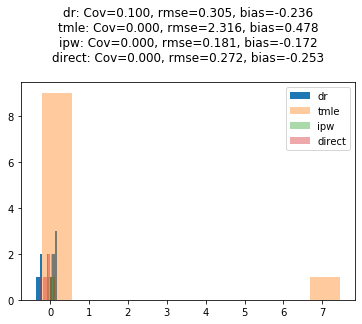

In [8]:
dr = np.array([r[0] for r in results])
tmle = np.array([r[1] for r in results])
ipw = np.array([r[2] for r in results])
direct = np.array([r[3] for r in results])
plot_results(dr, tmle, ipw, direct, true)

### Results from avg models

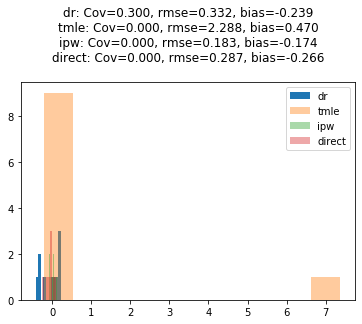

In [9]:
dr = np.array([r[4] for r in results])
tmle = np.array([r[5] for r in results])
ipw = np.array([r[6] for r in results])
direct = np.array([r[7] for r in results])
plot_results(dr, tmle, ipw, direct, true)